In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib nbagg
%matplotlib inline

see https://en.wikipedia.org/wiki/WordNet for details

In [2]:
import nltk
from nltk.corpus import wordnet as wn

targetWord = 'love'
syns = wn.synsets(targetWord)
wordCloud = []
wordCloudOriginal = []
wordCloudSim = [] # similarity to the target word
for word in syns:
    for lemma in word.lemmas():
        if lemma.name() not in wordCloudOriginal:
            wordCloudOriginal.append(str(lemma.name()))
            if wn.synsets(targetWord)[0].wup_similarity(wn.synsets(lemma.name())[0]) > 0.3:
                wordCloud.append(str(lemma.name()))
                wordCloudSim.append(wn.synsets(targetWord)[0].wup_similarity(wn.synsets(lemma.name())[0]))
            
wordCloud, wordCloudOriginal, wordCloudSim

(['love', 'passion', 'sexual_love', 'erotic_love', 'hump'],
 ['love',
  'passion',
  'beloved',
  'dear',
  'dearest',
  'honey',
  'sexual_love',
  'erotic_love',
  'lovemaking',
  'making_love',
  'love_life',
  'enjoy',
  'sleep_together',
  'roll_in_the_hay',
  'make_out',
  'make_love',
  'sleep_with',
  'get_laid',
  'have_sex',
  'know',
  'do_it',
  'be_intimate',
  'have_intercourse',
  'have_it_away',
  'have_it_off',
  'screw',
  'fuck',
  'jazz',
  'eff',
  'hump',
  'lie_with',
  'bed',
  'have_a_go_at_it',
  'bang',
  'get_it_on',
  'bonk'],
 [1.0, 0.7692307692307693, 0.6666666666666666, 0.6666666666666666, 0.4])

the problem with this is that, this list only contains 'lemmas' and not various forms of the words (loved, lover, loving, ...)

In [3]:
import os.path
import urllib

columns = ['ngram', 'year', 'match_count', 'volume_count']
dataf = pd.DataFrame(columns=columns)
for word in wordCloud:
    print word
    wordsp = word.split('_')
    n = len(wordsp)
    indices = word[:min(2,n)]
    filename = 'googlebooks-eng-all-{}gram-20120701-{}.gz'.format(n, indices)
    url = "http://storage.googleapis.com/books/ngrams/books/"+filename
    
    if not os.path.isfile(filename):
        urllib.urlretrieve (url, filename)
    elif int(urllib.urlopen(url).info()['Content-Length']) != os.stat(filename).st_size:
        urllib.urlretrieve (url, filename)
        
    for chunk in pd.read_table(filename, sep='\t', header=None, names=columns, chunksize=40000000):
        dataf = dataf.append(chunk[chunk.ngram == ' '.join(word.split('_'))], ignore_index=True)
        print sum(chunk.ngram == ' '.join(word.split('_')))
        
dataf.tail()

love
406
0
passion
391
0
0
sexual_love
0
0
0
0
0
0
0
0
0
0
197
erotic_love
117
hump
279
0


,ngram,year,match_count,volume_count
1385,hump,2004,14979,7805
1386,hump,2005,14485,7807
1387,hump,2006,14156,7643
1388,hump,2007,14985,8290
1389,hump,2008,18917,10656


In [4]:
dataf.to_csv('dataset_for_'+targetWord+'_wordCloud.csv.gz', sep=',', compression='gzip')

(0, 10)

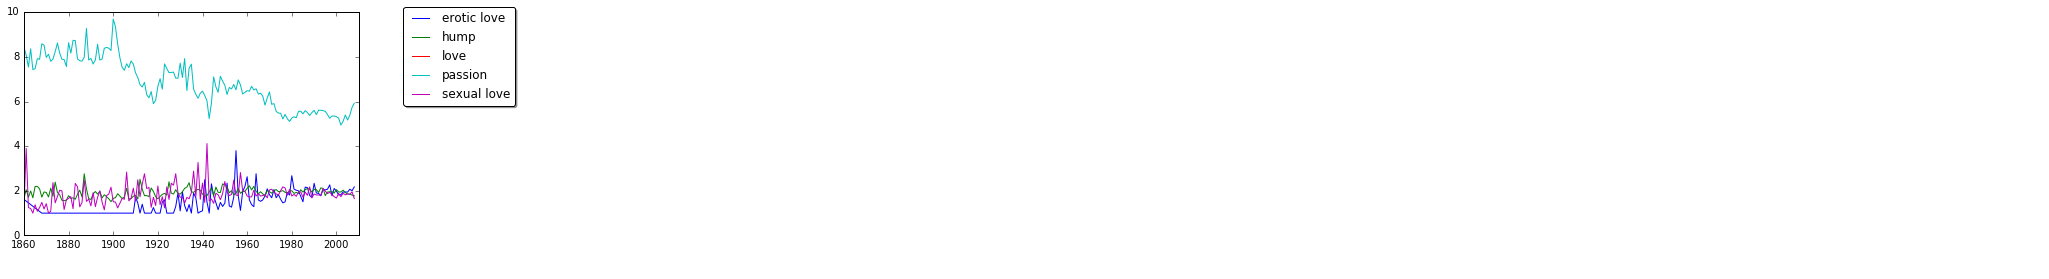

In [10]:
for key, grp in dataf.groupby(by='ngram'):
    plt.plot(grp.year, grp.match_count/grp.volume_count, label=key)
    plt.annotate(key, xy=(2016, grp.match_count[grp.year==2008]/grp.volume_count[grp.year==2008]))
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1.05), ncol=1, fancybox=True, shadow=True)
plt.xlim(1860,2010)
plt.ylim(0,10)

In [6]:
#data_check = pd.read_table('googlebooks-eng-all-1gram-20120701-d.gz', sep='\t', header=None, names=columns)

In [7]:
#plt.plot(data_check[data_check.ngram=='dog'].year, \
#         data_check[data_check.ngram=='dog'].match_count/data_check[data_check.ngram=='dog'].volume_count)
#plt.xlim(1850,2016)
#plt.ylim(5,12)

In [8]:
dataf_groups = dataf.groupby(by='year', as_index=True).sum()

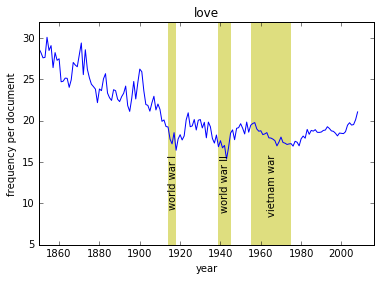

In [14]:
plt.plot(dataf_groups.index.values, dataf_groups.match_count/dataf_groups.volume_count)
# plt.plot(dataf[dataf.ngram=='love'].year, dataf[dataf.ngram=='love'].match_count/dataf[dataf.ngram=='love'].volume_count)
# plt.plot(dataf_groups.index.values, dataf_groups.match_count)
plt.axvspan(1914, 1918, color='y', alpha=0.5, lw=0)
plt.annotate('world war I', xy=(1914,15), rotation=np.degrees(3.14/2))
plt.axvspan(1939, 1945, color='y', alpha=0.5, lw=0)
plt.annotate('world war II', xy=(1940,15), rotation=np.degrees(3.14/2))
plt.axvspan(1955, 1975, color='y', alpha=0.5, lw=0)
plt.annotate('vietnam war', xy=(1963,15), rotation=np.degrees(3.14/2))
#plt.axvspan(1960, 2008, color='y', alpha=0.5, lw=0)
#plt.annotate('women liberation', xy=(1968,8), rotation=np.degrees(3.14/2))
plt.xlim(1850,2016)
plt.ylim(5,32)
plt.title(targetWord)
plt.xlabel('year')
plt.ylabel('frequency per document')
plt.savefig('dataset_for_'+targetWord+'_wordCloud.png')